In [1434]:
# %matplotlib inline

In [1435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

samples_dir = Path("data/movement_2/")
# P1, P2_2, P3, P4_1

MULTILATERATION_METHOD = "2d"
# MULTILATERATION_METHOD = "3d"

LANG = "PL"
# LANG = "EN"

KALMAN = True
SMOOTHE = True
# SMOOTHE = False

REMOVE_OUTLIERS = True

# These can be overridden by environment.json
MOVEMENT=False
REF_POINT="P1"

DEL_ANCHORS = [] # Default
# DEL_ANCHORS = ["0x6c0d"]
# DEL_ANCHORS = ["0x5601"]
# DEL_ANCHORS = ["0x26bd"]
# DEL_ANCHORS = ["0x5836"]

In [1436]:
dpi = 600
width_inches = 6
height_inches = width_inches * 3/4 
FONT_SIZE = 12

In [1437]:
# Try to get test environment conditions from JSON
import json

try:
    with open(samples_dir / "environment.json", "r") as file:
        settings = json.loads(file.read())
except:
    settings = dict()

if (TAG:=settings.get("tag")) is None:
    from data.points import TAG
if (ANCHORS := settings.get("anchors")) is None:
    from data.points import ANCHORS

In [1438]:
class AccelerometerOrientation:
    x_sign: int
    global_x: str
    y_sign: int
    global_y: str

    def __init__(self, setting: str) -> None:
        """
        Module orientation
        The arrow should point the same way as the back of the module (accelerometer's +Z axis)
        <------x-------
               ^       |
              -y       |
                       |
         <+x     -x>   y
                       |
              +y       |
               v       v
        """
        match setting:
            case "+x":
                data = (1, "acc_z", -1, "acc_y")
            case "-x":
                data = (-1, "acc_z", 1, "acc_y")
            case "+y":
                data = (1, "acc_y", 1, "acc_z")
            case "-y":
                data = (-1, "acc_y", -1, "acc_z")
            case _:
                raise ValueError(setting)

        self.x_sign, self.global_x, self.y_sign, self.global_y = data

ACCELEROMETER_ORIENTATION = AccelerometerOrientation(settings.get("acc_orientation") or "-y")

In [1439]:
folder_name = samples_dir.name.upper()

if folder_name.startswith("P"): 
    REF_POINT = samples_dir.name.upper()[:2]
else:
    MOVEMENT=True
    REF_POINT = settings.get("REF_POINT") or REF_POINT


filenames = [f for f in samples_dir.iterdir() if f.name.endswith(".csv")] if samples_dir.is_dir() else [samples_dir]
filenames.sort()
# filenames


In [1440]:
dfs = [pd.read_csv(f, index_col=0) for f in filenames]
#Remove unwanted anchors
dfs = [df[~df["anchor"].isin(DEL_ANCHORS)] for df in dfs]

In [1441]:
# Enforce same number of samples
if not MOVEMENT:
# if True:
    min_samples = min(len(df) for df in dfs)
    dfs = [df.head(min_samples) for df in dfs]

In [1442]:
for df in dfs:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

dfs = [df[df.anchor.isin(ANCHORS.keys())] for df in dfs]
dfs = [df.set_index("timestamp") for df in dfs]

anchors = dfs[0]["anchor"].unique()

# Multilateration

In [1443]:
from multilateration.solve import solve

solved_dfs = [solve(df, ANCHORS, MULTILATERATION_METHOD) for df in dfs]

In [1444]:
solved_dfs = [df.merge(solved_df, on="timestamp")[
    [
        "timestamp",
        "acc_x",
        "acc_y",
        "acc_z",
        "x",
        "y",
        "radius",
    ]
] for df, solved_df in zip(dfs, solved_dfs)]

# Convert to metric, remove gravitation
for df in solved_dfs:
    df[["x", "y"]] /= 1000
    df[["acc_x", "acc_y", "acc_z"]] *= 9.80665
    df[["acc_x", "acc_y", "acc_z"]] -= df[["acc_x", "acc_y", "acc_z"]].head(5).mean()


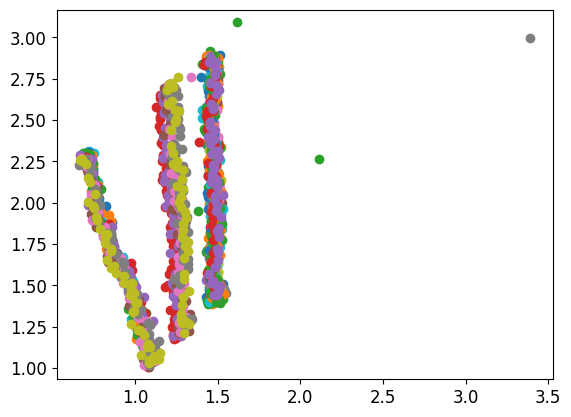

In [1445]:
for df in solved_dfs:
    plt.scatter(df["x"], df["y"])
plt.axis("equal")
plt.show()

In [1446]:
# Remove outliers

def remove_outliers(df, columns, threshold=3):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    return df_no_outliers

# Remove outliers from the DataFrame
if REMOVE_OUTLIERS:
    n_samples_before = sum(len(df) for df in solved_dfs)
    solved_dfs = [remove_outliers(df, ['x', 'y']) for df in solved_dfs]
    n_samples_after = sum(len(df) for df in solved_dfs)
    display(f"Deleted {n_samples_before-n_samples_after} samples. Left {n_samples_after} out of {n_samples_before} samples.")
    display(f"Removed {100*(1-n_samples_after/n_samples_before):.2f}% of samples")

'Deleted 8 samples. Left 1826 out of 1834 samples.'

'Removed 0.44% of samples'

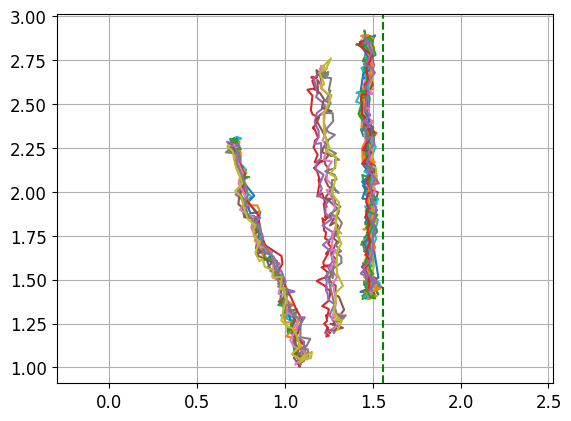

In [1447]:
for df in solved_dfs:
    if MOVEMENT:
        plt.plot(df["x"], df["y"])
    else:
        plt.scatter(df["x"], df["y"])


if MOVEMENT:
    plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
else:
    plt.scatter(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, color="green")
plt.axis("equal")
plt.grid(True)
plt.show()

In [1448]:
from math import sqrt
def p2p_dist(ax, ay, bx, by):
    return sqrt((bx - ax) ** 2 + (by - ay) ** 2)

def point_line_distance(x, y, a, b, c):
    return abs(a * x + b * y + c) / sqrt(a**2 + b**2)

In [1449]:
if MOVEMENT:
    # ax + by + c = 0
    a = 1
    b = 0
    c = - TAG[REF_POINT][0] / 1000
    calc_dist = lambda x: point_line_distance(x[0], x[1], a, b, c)
else:
    calc_dist = lambda x: p2p_dist(x[0], x[1], TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000)

for df in solved_dfs:
    df["error"] = df[["x", "y"]].apply(calc_dist, axis=1)
    

# Kalman filter

In [1450]:
def kalman_step(x, P, measurement, R, Q, F, H):
    # Predict
    x = F * x
    P = F * P * F.T + Q

    # Update
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R 
    K = P * H.T * S.I
    x = x + K * y
    I = np.matrix(np.eye(F.shape[0])) 
    P = (I - K * H) * P

    return x, P

In [1451]:
kalman_dfs = []
if KALMAN:
    for df in solved_dfs:
        # dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6
        dt = df["timestamp"].diff().dropna().mean().to_timedelta64().astype('float64')/1e9


        F = np.matrix(
            [[1, 0, dt**2 / 2, 0], [0, 1, 0, dt**2 / 2], [0, 0, 1, 0], [0, 0, 0, 1]]
        )
        H = np.matrix(np.eye(4))

        # Q = np.matrix(np.diag([0.0001, 0.0001, 0.01, 0.00000001]))
        # Q = np.matrix(np.diag([0.0001, 0.0001, 0.01, 0.01]))
        # Q = np.matrix(np.diag([0.0002, 0.0002, 0.001, 0.001]))
        Q = np.matrix(np.diag([0.0002, 0.0002, 0.0001, 0.0001])) # best one
        if MOVEMENT:
            # R = np.matrix(np.diag([8e-5, 8e-5, 3e-4, 3e-4]))
            R = np.matrix(np.eye(4) * 2e-4)
        else:
            R = np.matrix(
                np.diag(
                    [
                        df["x"].std() ** 2,
                        df["y"].std() ** 2,
                        df[ACCELEROMETER_ORIENTATION.global_x].std() ** 2,
                        df[ACCELEROMETER_ORIENTATION.global_y].std() ** 2,
                    ]
                )
            )
            # display(R)

        P = np.matrix(np.eye(4)) * 100
        x = np.matrix("0. 0. 0. 0.").T


        # Filter
        filtered = []
        for _, measurement in df[
            [
                "x",
                "y",
                ACCELEROMETER_ORIENTATION.global_x,
                ACCELEROMETER_ORIENTATION.global_y,
            ]
        ].iterrows():
            measurement = measurement.to_list()
            measurement = [
                measurement[0],  # x
                measurement[1],  # y
                ACCELEROMETER_ORIENTATION.x_sign * measurement[2],  # x
                ACCELEROMETER_ORIENTATION.y_sign * measurement[3],  # y
            ]
            x, P = kalman_step(x, P, measurement, R, Q, F, H)
            filtered.append(x.tolist())

        filtered_pos = [[x[0], y[0]] for (x, y, _, _) in filtered]
        kalman_dfs.append(pd.DataFrame(filtered_pos, columns=["x", "y"]))
else:
    kalman_dfs = [df[["x","y"]].copy() for df in solved_dfs]

In [1452]:
if SMOOTHE:
    kalman_smooth_dfs = [df.copy() for df in kalman_dfs]
    for df in kalman_smooth_dfs:
        df[["x", "y"]] = df[["x", "y"]].rolling(window=3).mean()
        df["error"] = df.apply(calc_dist, axis=1)

for df in kalman_dfs:
    df["error"] = df.apply(calc_dist, axis=1)

In [1453]:
import plotly.express as px
import plotly.graph_objects as go

# for i, df in enumerate(solved_dfs):
#     plt.plot(df["error"], label=i)
# plt.legend()
# plt.show()

data = {i: df for i, df in enumerate(solved_dfs)}
fig = go.Figure()

for i in data:
    fig = fig.add_trace(go.Line(y = data[i]["error"], 
                                   name = i))
fig.show()

/home/piotr/Documents/mgr/uwb-rs/data-processing/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [1454]:
# All error Kalman vs no Kalman

# for df_k, df_u in zip(kalman_dfs, solved_dfs):
#     plt.plot(df_k["error"], "-o", label="Kalman")
#     plt.plot(df_u["error"], "-o", label="UWB")
#     plt.legend()
#     plt.ylabel("Absolute error [m]")
#     plt.xlabel("Sample index")
#     plt.grid(True)
#     plt.show()

# Mean

In [1455]:
all_kalman = pd.concat(kalman_dfs, ignore_index=True)
all_uwb = pd.concat(solved_dfs, ignore_index=True)
if SMOOTHE:
    all_smooth = pd.concat(kalman_smooth_dfs, ignore_index=True)

In [1456]:
kalman = pd.concat(kalman_dfs)
kalman = kalman.groupby(kalman.index).mean()

solved = pd.concat(solved_dfs)
solved = solved[["x", "y", "error", "timestamp"]]
solved = solved.groupby(solved.index).mean()

if SMOOTHE:
    smooth = pd.concat(kalman_smooth_dfs)
    smooth = smooth.groupby(smooth.index).mean()


# old_dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6
# dt = all_uwb["timestamp"].diff().dropna().mean().to_timedelta64().astype('float64')/1e9

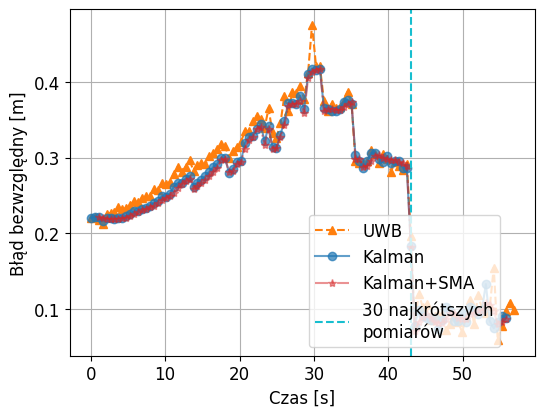

In [1457]:
# def gen():
#     last = 1
#     while True:
#         try:
#             last = next(solved_dfs[0]["timestamp"].diff().fillna(0).to_numpy())
#             yield last
#         except StopIteration:
#             yield last
# g = gen()
# x = [next(g) for _ in range(len(kalman["error"]))]
# x_k = x.copy()
def error_over_time_plot(solved, kalman, smooth, solved_dfs, width_inches, height_inches, dpi, suffix=""):
    x = [i * dt for i in range(len(solved["error"]))]
    x_k = [i * dt for i in range(len(kalman["error"]))]

    plt.rcParams['font.size'] = FONT_SIZE
    plt.plot(x, solved["error"], "--^", label="UWB", c="tab:orange")
    plt.plot(x_k, kalman["error"], "-o", label="Kalman", c="tab:blue", alpha=0.7)
    if SMOOTHE:
        plt.plot(x_k, smooth["error"], linestyle="dashdot", marker="*", label="Kalman+SMA", c="tab:red", alpha=0.5)

    shortest_meas_marker = 30
    if MOVEMENT and len(solved_dfs) > shortest_meas_marker:
        n_of_samples = [len(df) for df in solved_dfs]
        n_of_samples.sort()
        end_of_30th_sample = n_of_samples[shortest_meas_marker]
        plt.axvline(x[end_of_30th_sample], ls="--", c="tab:cyan", label=f"{shortest_meas_marker} shortest measurements" if LANG=="EN" else f"{shortest_meas_marker} najkrótszych\npomiarów")

    legend_loc = "best"
    legend_bbox = None
    # Custom legend placement
    match REF_POINT:
        case "P1":
            legend_loc = "lower center"
            legend_bbox = (0.72,0)

    plt.legend(loc=legend_loc, bbox_to_anchor=legend_bbox)
    plt.ylabel("Absolute error [m]" if LANG=="EN" else "Błąd bezwzględny [m]")
    plt.xlabel("Time [s]" if LANG=="EN" else "Czas [s]")
    plt.grid(True)
    plt.gcf().set_size_inches(width_inches, height_inches)
    plt.savefig(f"plots_output/errors_over_time_{str(samples_dir).replace('/', '_')}_{REF_POINT}" 
                + (f"_deleted_{'_'.join(DEL_ANCHORS)}" if DEL_ANCHORS else "")
                + suffix
                + ".png",
                dpi=dpi, bbox_inches='tight')
    plt.show()

error_over_time_plot(solved, kalman, smooth, solved_dfs, width_inches, height_inches, dpi)

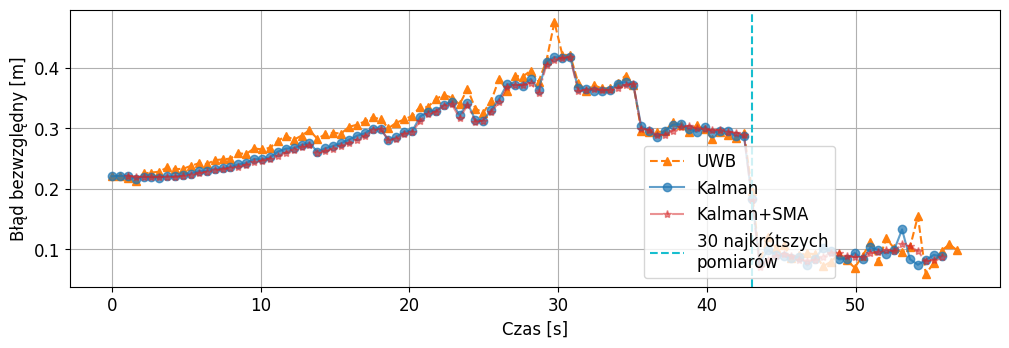

In [1458]:
error_over_time_plot(solved, kalman, smooth, solved_dfs, width_inches*2, height_inches*0.8, dpi, "wide")

data/movement_2/2023-07-07-17:40:46.444178move2-1.csv


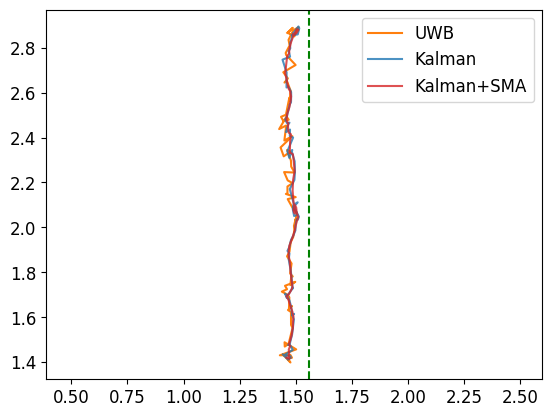

data/movement_2/2023-07-07-17:42:06.993385move2-2.csv


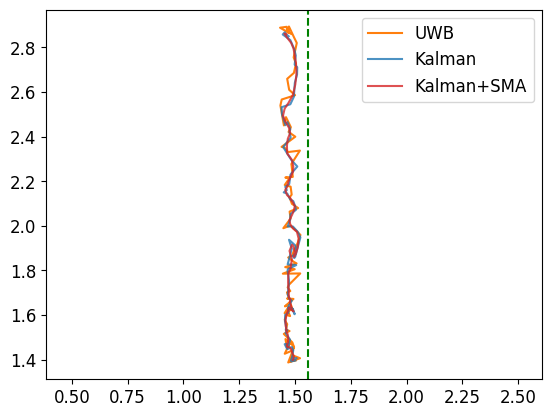

data/movement_2/2023-07-07-17:43:26.951057move2-3.csv


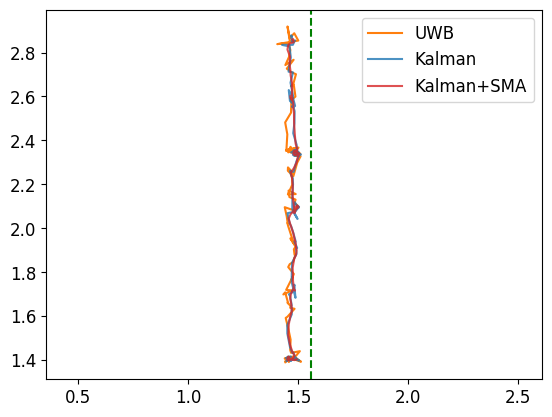

In [1459]:
# Trace/scatter for every data set
n_plots = 3
for filename, df, kdf, sdf in zip(filenames[:n_plots], solved_dfs[:n_plots], kalman_dfs[:n_plots], kalman_smooth_dfs[:n_plots]):
    if MOVEMENT:
        plt.plot(df.x, df.y, "-", color="tab:orange", label="UWB")
        plt.plot(kdf.x, kdf.y, "-", color="tab:blue", label="Kalman", alpha=0.8)
        if SMOOTHE:
            plt.plot(sdf.x, sdf.y, "-", color="tab:red", label="Kalman+SMA", alpha=0.8)

        plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
    else:
        plt.scatter(kdf.x, kdf.y, color="tab:blue", label="Kalman")
        plt.scatter(df.x, df.y, color="tab:orange" ,label="UWB")
        if SMOOTHE:
            plt.scatter(sdf.x, sdf.y, color="tab:red" ,label="Kalman+SMA")
        plt.plot(TAG[REF_POINT][0]/1000, TAG[REF_POINT][1]/1000, "g1")
    plt.axis("equal")
    plt.legend()
    print(filename)
    plt.show()

In [1460]:
import seaborn as sns

x_y_comparison_df = pd.concat([all_kalman.copy().assign(name="Kalman"),
                               all_uwb[["x", "y", "error"]].copy().assign(name="UWB"),
                               all_smooth[["x", "y", "error"]].copy().assign(name="Kalman+SMA")])

In [1461]:

# # plt.title("Bivariate distribution of positioning results.")
# if MOVEMENT:
#     sns.jointplot(
#         data=x_y_comparison_df,
#         x="x",
#         y="y",
#         hue="name",
#         # kind="kde",
#         # bw_adjust=0.9,
#     )
#     # for df in kalman_dfs:
#     #     plt.plot(df.x, df.y, color="blue")
#     # for df in solved_dfs:
#     #     plt.plot(df.x, df.y, color="orange")
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
# else:    
#     sns.jointplot(
#         data=x_y_comparison_df,
#         x="x",
#         y="y",
#         hue="name",
#         kind="kde",
#         levels=[0.1, 0.3, 0.5, 0.7, 0.9],
#     )
#     plt.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "go")
# ax = plt.gca()
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# ax.get_legend().set_title("")
# plt.grid()
# plt.gcf().set_size_inches(width_inches, width_inches)
# plt.savefig(f"plots_output/kde_{str(samples_dir).replace('/', '_')}_{REF_POINT}.png", dpi=dpi, bbox_inches='tight')
# plt.show()

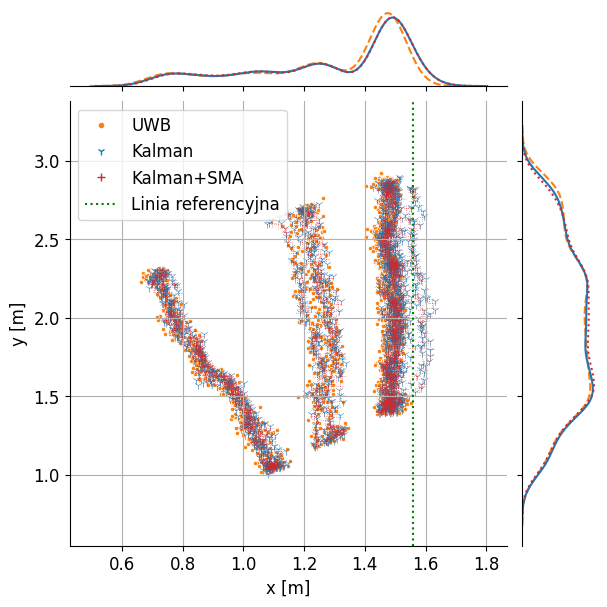

In [1476]:
plt.rcParams['font.size'] = FONT_SIZE
g = sns.JointGrid()
if not MOVEMENT:
    # Main plot
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyles="dashed",
            label="UWB",
            ax=g.ax_joint,
            color="tab:orange",
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_joint
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                x="x",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyles="dotted",
                color="tab:red",
                label="Kalman+SMA",
                ax=g.ax_joint
            )
        
    g.ax_joint.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "go")

    # Top marginal (x)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_x
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_marg_x
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                x="x",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyle=":",
                color="tab:red",
                label="Kalman+SMA",
                ax=g.ax_marg_x
            )

    # Right marginal (y)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_y
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            label="Kalman",
            color="tab:blue",
            ax=g.ax_marg_y
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyle=":",
                label="Kalman+SMA",
                color="tab:red",
                alpha=0.6,
                ax=g.ax_marg_y
            )
        
    custom_legend_handles = [plt.Line2D([], [], linestyle='--', color='tab:orange', label='UWB'),
                        plt.Line2D([], [], linestyle='-', color='tab:blue', label='Kalman'),
                            ]
    if SMOOTHE:
        custom_legend_handles.append(plt.Line2D([], [], linestyle=':', color='tab:red', label='Kalman+SMA'))
    custom_legend_handles.append(plt.Line2D([], [], linestyle='None', marker="o", color="g", label="Reference point"  if LANG=="EN" else "Punkt referencyjny"))
else:
    # Main plot
    sns.scatterplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            # linestyles="dashed",
            label="UWB",
            ax=g.ax_joint,
            marker=".",
            color="tab:orange",
            # sort=False,
        )
    sns.scatterplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            alpha=0.8,
            marker="1",
            label="Kalman",
            ax=g.ax_joint,
            # sort=False,
        )
    if SMOOTHE:
        sns.scatterplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                x="x",
                # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                color="tab:red",
                linestyle=":",
                alpha=0.6,
                marker="+",
                label="Kalman+SMA",
                ax=g.ax_joint,
                # sort=False,
            )
    g.ax_joint.axvline(TAG[REF_POINT][0] / 1000, linestyle="dotted", color="g")

    # # Top marginal (x)
    # sns.histplot(
    #         data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
    #         x="x",
    #         # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
    #         linestyle="dashed",
    #         label="UWB",
    #         color="tab:orange",
    #         ax=g.ax_marg_x
    #     )
    # sns.histplot(
    #         data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
    #         x="x",
    #         # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
    #         color="tab:blue",
    #         label="Kalman",
    #         ax=g.ax_marg_x
    #     )
    # sns.histplot(
    #         data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
    #         x="x",
    #         # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
    #         color="tab:green",
    #         label="Kalman+SMA",
    #         ax=g.ax_marg_x
    #     )

    # # Right marginal (y)
    # sns.histplot(
    #         data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
    #         y="y",
    #         # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
    #         linestyle="dashed",
    #         label="UWB",
    #         color="tab:orange",
    #         ax=g.ax_marg_y
    #     )
    # sns.histplot(
    #         data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
    #         y="y",
    #         # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
    #         label="Kalman",
    #         color="tab:blue",
    #         ax=g.ax_marg_y
    #     )
    # if SMOOTHE:
        # sns.histplot(
        #         data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
        #         y="y",
        #         # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
        #         label="Kalman+SMA",
        #         linestyle=":",
        #         color="tab:green",
        #         ax=g.ax_marg_y
        #     )

    BW = 1

    # Top marginal (x)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_x,
            bw_adjust=BW,
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            bw_adjust=BW,
            label="Kalman",
            ax=g.ax_marg_x
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                x="x",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                color="tab:red",
                linestyle=":",
                label="Kalman+SMA",
                bw_adjust=BW,
                ax=g.ax_marg_x
            )
    # Right marginal (y)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            bw_adjust=BW,
            ax=g.ax_marg_y
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            label="Kalman",
            color="tab:blue",
            ax=g.ax_marg_y,
            bw_adjust=BW,

        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyle=":",
                label="Kalman+SMA",
                color="tab:red",
                bw_adjust=BW,
                ax=g.ax_marg_y
            )
    custom_legend_handles = [plt.Line2D([], [], linestyle='', marker=".", color='tab:orange', label='UWB'),
                            plt.Line2D([], [], linestyle='', marker="1", color='tab:blue', label='Kalman'),
                            ]
    if SMOOTHE:
        custom_legend_handles.append(plt.Line2D([], [], linestyle='', marker="+", color='tab:red', label='Kalman+SMA'))
    custom_legend_handles.append(plt.Line2D([], [], linestyle='dotted', color="g", label="Reference line"  if LANG=="EN" else "Linia referencyjna"))
custom_legend_labels = [handle.get_label() for handle in custom_legend_handles]

# Add the custom legend to the plot
legend_loc = "best"
legend_bbox = None
# Custom legend placement
match REF_POINT:
    case "P2":
        legend_loc = "center"
        legend_bbox = (0.5,0.6)

g.ax_joint.legend(handles=custom_legend_handles, labels=custom_legend_labels, loc=legend_loc, bbox_to_anchor=legend_bbox)
g.ax_joint.set_xlabel("x [m]")
g.ax_joint.set_ylabel("y [m]")
g.ax_joint.grid()
plt.gcf().set_size_inches(width_inches, width_inches)
plt.savefig(f"plots_output/kde_{str(samples_dir).replace('/', '_')}_{REF_POINT}"
            + (f"_deleted_{'_'.join(DEL_ANCHORS)}" if DEL_ANCHORS else "") 
            + ".png"
            , dpi=dpi, bbox_inches='tight')
plt.show()


In [1463]:
# if MOVEMENT:
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "UWB"]
#     plt.plot(_df["x"], _df["y"], label="UWB")
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"]
#     plt.plot(_df["x"], _df["y"], label="Kalman")
# else:
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "UWB"]
#     plt.scatter(_df["x"], _df["y"], label="UWB")
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"]
#     plt.scatter(_df["x"], _df["y"], label="Kalman")


# if MOVEMENT:
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
# else:
#     plt.scatter(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, color="green")
# plt.axis("equal")
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# plt.legend()
# plt.grid(True)
# plt.show()

# RMSE

In [1464]:
if SMOOTHE:
    errors = pd.concat(
        [all_uwb["error"],all_kalman["error"], all_smooth["error"]],
        axis=1,
        keys=["UWB", "Kalman", "Kalman+SMA"],
    )
else:
    errors = pd.concat(
        [all_uwb["error"],all_kalman["error"]],
        axis=1,
        keys=["UWB", "Kalman"],
    )
rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

display(f"N. of series: {len(filenames)}; N. of samples: {len(all_uwb)}")
for series, value in rmse.items():
    print(f"{series:30}{value*100:.1f}cm")
print()
for series, value in rmse.items():
    percentage = value/rmse['UWB']*100
    change = -(rmse['UWB'] - value) / rmse['UWB']*100
    print(f"{series:30}{percentage:.1f}%\t{change:.1f}%")
# print(f"{'UWB':30}{100}%\t(0%)")
# print(f"{'Kalman':30} {(rmse['UWB'] - rmse['Kalman']) / rmse['UWB']*100:.1f}%")
# print(f"{'Kalman'} {(rmse['UWB'] - rmse['Kalman+SMA']) / rmse['UWB']*100:.1f}%")

'N. of series: 35; N. of samples: 1826'

UWB                           38.2cm
Kalman                        37.4cm
Kalman+SMA                    37.3cm

UWB                           100.0%	-0.0%
Kalman                        97.8%	-2.2%
Kalman+SMA                    97.5%	-2.5%


# Standard deviation

In [1465]:
# print(e_std:=errors.std())
# print(f"Poprawa Kalman vs UWB{(e_std['UWB'] - e_std['Kalman']) / e_std['UWB']*100:.1f}%")
# print(f"Poprawa Kalman+SMA vs UWB{(e_std['UWB'] - e_std['Kalman+SMA']) / e_std['UWB']*100:.1f}%")
e_std = errors.std()
for series, value in e_std.items():
    print(f"{series:30}{value*100:.1f}cm")
print()
for series, value in e_std.items():
    percentage = value/e_std['UWB']*100
    change = -(e_std['UWB'] - value) / e_std['UWB']*100
    print(f"{series:30}{percentage:.1f}%\t{change:.1f}%")

UWB                           25.5cm
Kalman                        25.7cm
Kalman+SMA                    25.6cm

UWB                           100.0%	-0.0%
Kalman                        100.8%	0.8%
Kalman+SMA                    100.5%	0.5%


# Trajectory slices

0 10


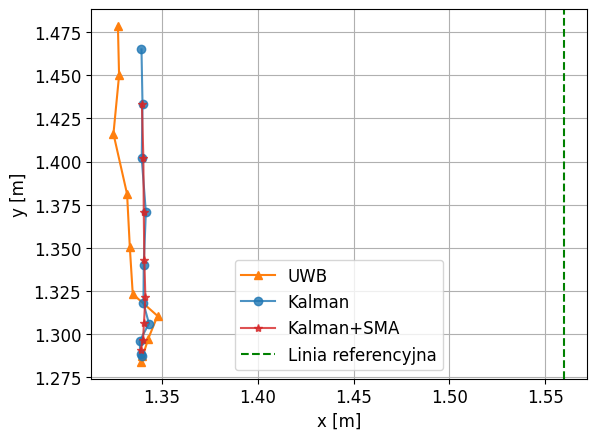

10 20


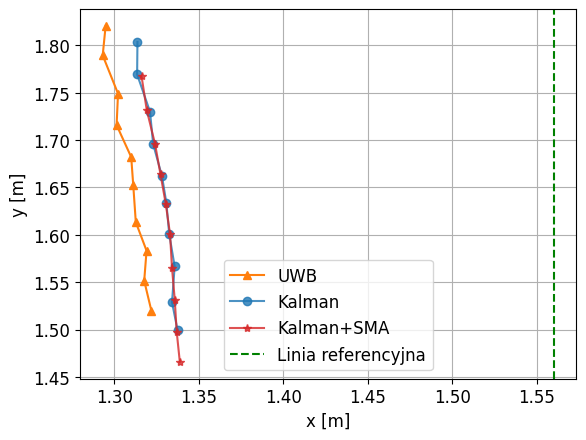

20 30


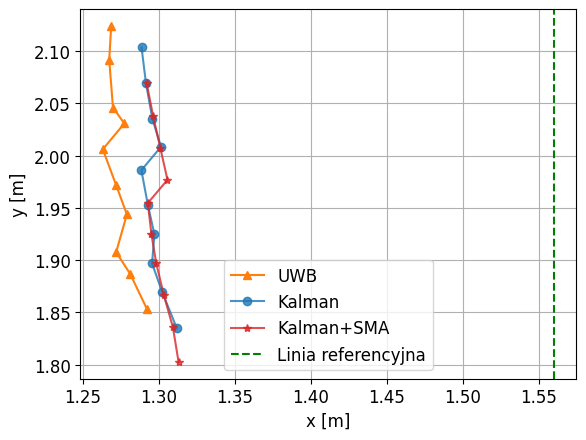

30 40


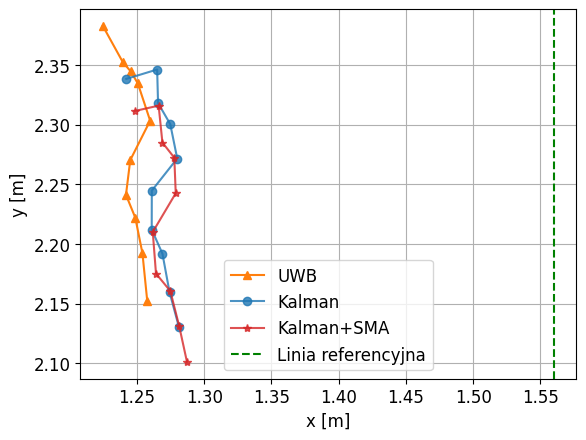

40 50


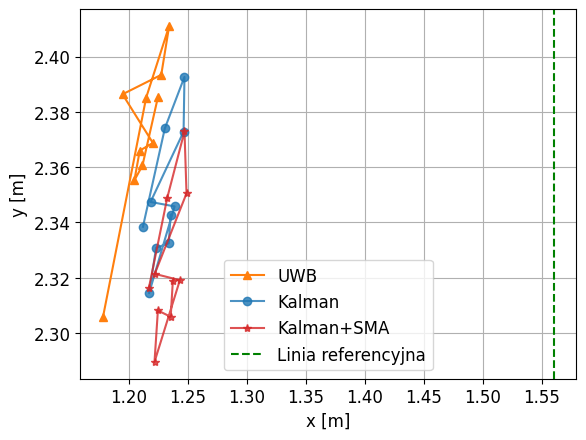

50 60


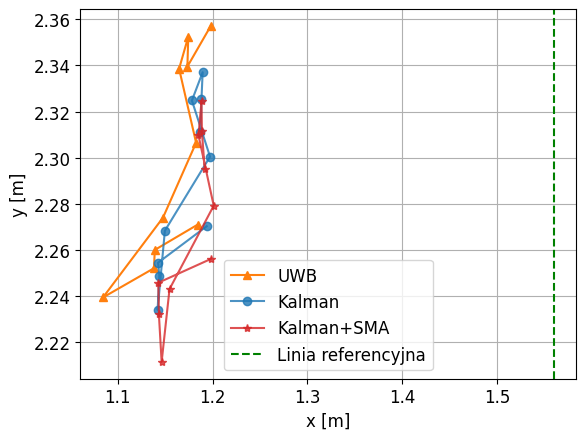

60 70


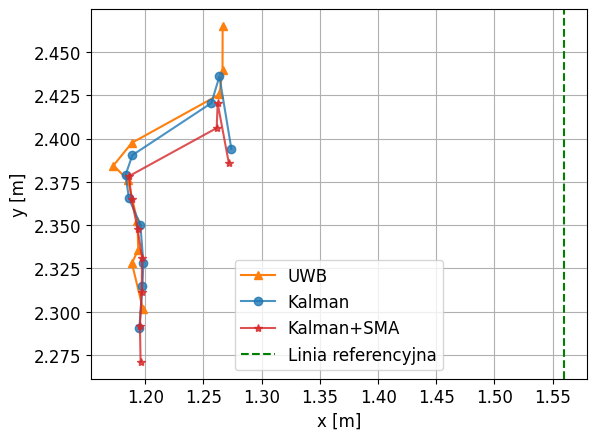

70 80


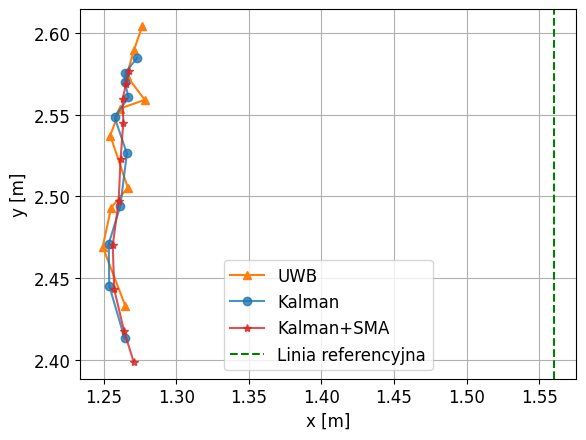

80 90


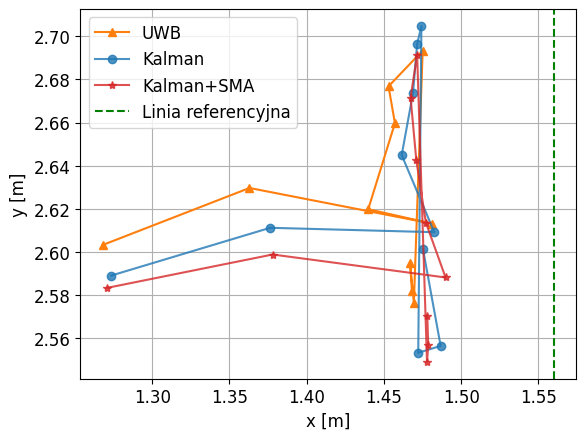

90 100


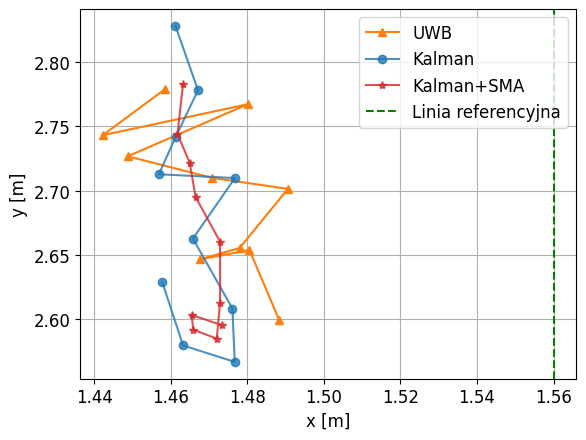

In [1466]:
# Trace/scatter for every data set
if MOVEMENT:
    slice_len = 10
    for i in range(slice_len,len(solved), slice_len):
        if MOVEMENT:
            plt.plot(solved.x[i-slice_len:i], solved.y[i-slice_len:i], "-^", color="tab:orange", label="UWB")
            plt.plot(kalman.x[i-slice_len:i], kalman.y[i-slice_len:i], "-o", color="tab:blue", label="Kalman", alpha=0.8)
            if SMOOTHE:
                plt.plot(smooth.x[i-slice_len:i], smooth.y[i-slice_len:i], "-*", color="tab:red", label="Kalman+SMA", alpha=0.8)

            plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--", label="Reference line" if LANG=="EN" else "Linia referencyjna")
        else:
            plt.scatter(kalman.x[i-slice_len:i], kalman.y[i-slice_len:i], color="tab:blue", label="Kalman")
            plt.scatter(solved.x[i-slice_len:i], solved.y[i-slice_len:i], color="tab:orange" ,label="UWB")
            if SMOOTHE:
                plt.scatter(smooth.x[i-slice_len:i], smooth.y[i-slice_len:i], color="tab:red" ,label="Kalman+SMA")
            plt.plot(TAG[REF_POINT][0]/1000, TAG[REF_POINT][1]/1000, "g1")
        # plt.axis("equal")
        plt.grid(True)
        plt.legend()
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        print(i-slice_len, i)
        plt.show()

# RMSE when ref point = mean point

In [1467]:
# if MOVEMENT:
#     c = - all_kalman.x.mean()
#     calc_dist_kalman = lambda x: point_line_distance(x[0], x[1], a, b, c)
#     calc_dist_uwb = lambda x: point_line_distance(x[0], x[1], a, b, c)
# else:
#     ref_point_kalman = (all_kalman.x.mean(), all_kalman.y.mean())
#     ref_point_uwb = (all_uwb.x.mean(), all_uwb.y.mean())
#     calc_dist_kalman = lambda x: p2p_dist(x[0], x[1], *ref_point_kalman)
#     calc_dist_uwb = lambda x: p2p_dist(x[0], x[1], *ref_point_uwb)

In [1468]:
# for df in kalman_dfs:
#     df["error"] = df[["x","y"]].apply(calc_dist_kalman, axis=1)

# for df in solved_dfs:
#     df["error"] = df[["x","y"]].apply(calc_dist_uwb, axis=1)

In [1469]:
# all_kalman_ref = pd.concat(kalman_dfs, ignore_index=True)
# all_uwb_ref = pd.concat(solved_dfs, ignore_index=True)

# errors = pd.concat(
#     [all_kalman_ref["error"], all_uwb_ref["error"]],
#     axis=1,
#     keys=["Kalman (UWB+accelerometer)"  if LANG=="EN" else "Kalman (UWB i akcelerometr)", "UWB"],
# )
# rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

# rmse, rmse.diff()

# RMSE with line fitting

In [1470]:
# if MOVEMENT:
#     for df, kdf in zip(solved_dfs, kalman_dfs):
#         # Swap x and y to have small "a" coefficient values
#         x = df['y'].values
#         y = df['x'].values


#         k_x = kdf["y"].values
#         k_y = kdf["x"].values

#         # Calculating the coefficients of the line using least squares method
#         A = np.vstack([x, np.ones(len(x))]).T
#         m, c = np.linalg.lstsq(A, y, rcond=None)[0]

#         # Creating the line equation string
#         # line_equation = f'y = {m:.2f}x + {c:.2f}'

#         # Generating the predicted y-values for the line
#         y_pred = m * x + c

#         # Calculate errors
#         # ax + by + c = 0
#         a = m
#         b = -1
#         df["fitted_error"] = [point_line_distance(_x, _y, a, b, c) for _x,_y in zip(x,y)]
#         kdf["fitted_error"] = [point_line_distance(_x, _y, a, b, c) for _x,_y in zip(k_x,k_y)]

#         # # Plotting the original data points and the fitted line
#         # plt.plot(y,x, label='UWB')
#         # plt.plot(k_y, k_x, label='Kalman')
#         # plt.plot(y_pred, x, 'r', label='Fitted Line')
#         # plt.xlabel('x')
#         # plt.ylabel('y')
#         # # plt.title('Line Fitting')
#         # plt.axis("equal")   
#         # plt.legend()

#         # # Displaying the line equation and the plot
#         # # print('Line Equation:', line_equation)
#         # plt.show()


#     all_kalman_fitted = pd.concat(kalman_dfs, ignore_index=True)
#     all_uwb_fitted = pd.concat(solved_dfs, ignore_index=True)

#     errors = pd.concat(
#         [all_kalman_fitted["fitted_error"], all_uwb_fitted["fitted_error"]],
#         axis=1,
#         keys=["Kalman (UWB+accelerometer)" if LANG=="EN" else "Kalman (UWB i akcelerometr)", "UWB"],
#     )
#     rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

#     display(rmse, rmse.diff())

# Movement curvature comparison

In [1471]:
# if MOVEMENT:
#     def calculate_curvature(x, y):
#         dx = np.gradient(x)
#         dy = np.gradient(y)
#         d2x = np.gradient(dx)
#         d2y = np.gradient(dy)

#         curvature = (dx * d2y - dy * d2x) / (dx**2 + dy**2)**(3/2)
#         return curvature

#     def average_curvature(x, y):
#         curvature = calculate_curvature(x, y)
#         avg_curvature = np.mean(np.abs(curvature))
#         return avg_curvature

#     def path_is_smoother(path1, path2, path1_name="Path 1", path2_name="Path 2"):
#         x1, y1 = path1["x"], path1["y"]
#         x2, y2 = path2["x"], path2["y"]

#         smooth_path_curvature_1 = average_curvature(x1, y1)
#         smooth_path_curvature_2 = average_curvature(x2, y2)

#         # if smooth_path_curvature_1 < smooth_path_curvature_2:
#             # print(f"{path1_name} is smoother than {path2_name}.")
#         # else:
#             # print(f"{path2_name} is smoother than {path1_name}.")
#         return (smooth_path_curvature_1, smooth_path_curvature_2)

In [1472]:
# if MOVEMENT:
#     results = []
#     for udf, kdf in zip(solved_dfs, kalman_dfs):
#         pc_uwb, pc_k = path_is_smoother(udf, kdf, "UWB", "Kalman")
#         results.append(pc_k < pc_uwb)
#     print(f"Percentage of smoother Kalman paths: {results.count(True)/len(results)}")



# Vector field

In [1473]:
# fig, ax = plt.subplots()
# xy_len = len(solved_dfs[0].x)
# ax.quiver(solved_dfs[0].x, solved_dfs[0].y, (kalman_dfs[0].x - solved_dfs[0].x)[:xy_len], (kalman_dfs[0].y - solved_dfs[0].y)[:xy_len], angles="xy", scale=2, width=0.003)
# ax.plot(all_uwb.x, all_uwb.y, c="tab:orange", alpha=0.4)
# ax.set(xlim=(0, 3.5), ylim=(0, 4.5))

In [1474]:
# if MOVEMENT:
#     import matplotlib.animation as animation
#     from IPython.core.display import HTML

#     plt.rcParams["animation.html"] = "jshtml"
#     plt.rcParams['figure.dpi'] = 150  
#     plt.ioff()
#     fig, ax = plt.subplots()

#     line_uwb = ax.plot(solved_dfs[0].x, solved_dfs[0].y, "-", c="tab:orange", label="UWB", marker=".")[0]
#     line_kalman = ax.plot(kalman_dfs[0].x, kalman_dfs[0].y, "-", alpha=0.7, c="tab:blue", label="Kalman", marker=".")[0]
#     plt.legend()
#     limit = 15
#     X = solved_dfs[0].x[:limit]
#     Y = solved_dfs[0].y[:limit]
#     U = (kalman_dfs[0].x - solved_dfs[0].x)[:xy_len][:limit]
#     V = (kalman_dfs[0].y - solved_dfs[0].y)[:xy_len][:limit]
#     # plt.axis('equal')
#     plt.xlim(0, 3.5)
#     plt.ylim(0, 4.5)
#     vec = ax.quiver(X, Y, U, V, angles="xy", scale=1, width=0.003)

#     def update(frame):
#         x = solved_dfs[0].x.iloc[frame-10:frame]
#         y = solved_dfs[0].y.iloc[frame-10:frame]

#         line_uwb.set_xdata(x)
#         line_uwb.set_ydata(y)

#         xk = kalman_dfs[0].x.iloc[frame-10:frame]
#         yk = kalman_dfs[0].y.iloc[frame-10:frame]
#         line_kalman.set_xdata(xk)
#         line_kalman.set_ydata(yk)

#         return (line_uwb, line_kalman)
#     display(animation.FuncAnimation(fig=fig, func=update, frames=len(solved_dfs[0]), interval=100))

In [1475]:
# plt.cla()